In [1]:
# Блокнот демонстрирует функционал использования класса PoseMultiple на примере кадов с рендера

In [2]:
# Импортирование модулей

In [3]:
import os, sys

In [4]:
base_dir = os.path.split(os.getcwd())[0]
os.chdir(os.path.join(base_dir))
sys.path.append("core")

In [5]:
import pickle as pk

import numpy as np
import cv2
import sys
import argparse
import time
import copy
import datetime
from time import time

import matplotlib.pyplot as plt

from core.utils import ARUCO_DICT, display_pose
from core.estimators import PoseSingle, PoseMultiple

In [6]:
from scipy.spatial.transform import Rotation as R

In [7]:
# Создание экземпляра класса PoseSingle 

In [8]:
# путь к матрице калибровки
calibration_matrix_path = "calib/calibration_matrix_render.npy"
# путь к коэффициентам дисторсии
distortion_coefficients_path = "calib/distortion_coefficients_render.npy"
# длина стороны маркера в метрах
edge_len = 0.7
# шаг, с которым маркеры установлены
marker_step = 10
# максимальное число маркеров
n_markers = 100

# тип маркеров (в проде будет "DICT_5X5_50" !!!)
type_ = "DICT_7X7_100"
if ARUCO_DICT.get(type_, None) is None:
    print(f"ArUCo tag type '{type_}' is not supported")
    sys.exit(0)
aruco_dict_type = ARUCO_DICT[type_]

k = np.load(calibration_matrix_path)
d = np.load(distortion_coefficients_path)

# Создание двух сингл эстимэйторов

# Эстимэйтор для фронтальной камеры! 
estimator_front = PoseSingle(
    aruco_dict_type,
    1, # ориентация камеры: -1 для задней камеры, 1 для фронтальной !!!
    n_markers,
    marker_step,
    edge_len,
    k,
    d)

# Эстимэйтор для задней камеры! 
estimator_rear = PoseSingle(
    aruco_dict_type,
    -1, # ориентация камеры: -1 для задней камеры, 1 для фронтальной !!!
    n_markers,
    marker_step,
    edge_len,
    k,
    d)

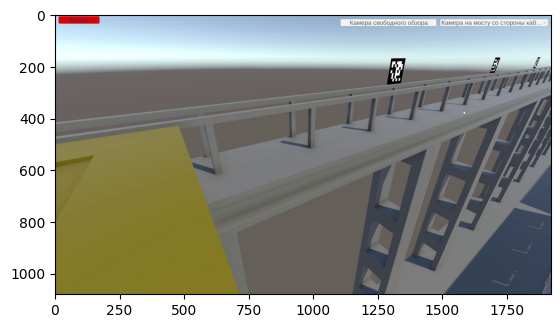

In [9]:
# Загрузка кадра с фронтальной камеры
image_front = 'demo_data/front.png'
image_front = cv2.imread(image_front)
plt.imshow(cv2.cvtColor(image_front, cv2.COLOR_BGR2RGB))
plt.show()

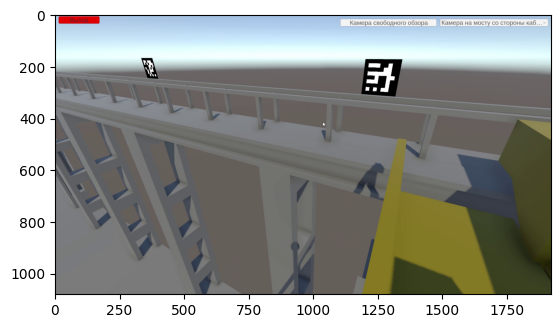

In [10]:
# Загрузка кадра с задней камеры
image_rear = 'demo_data/rear.png'
image_rear = cv2.imread(image_rear)
plt.imshow(cv2.cvtColor(image_rear, cv2.COLOR_BGR2RGB))
plt.show()

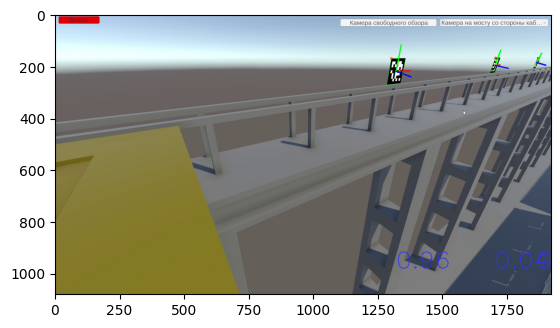

[[ 0.92843507 -0.14224975  0.34318118 -6.2141976 ]
 [ 0.36949464  0.44932436 -0.8133765   5.89720054]
 [-0.03849706  0.88197088  0.46972902 -1.37508798]
 [ 0.          0.          0.          1.        ]]


In [11]:
frame, pose, size = estimator_front(image_front, True)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
print(pose)

C:\Users\vmart\PycharmProjects\cranpos\core\campose.py:390: RuntimeWarning: invalid value encountered in divide
  left_x_weights /= sum(left_x_weights)


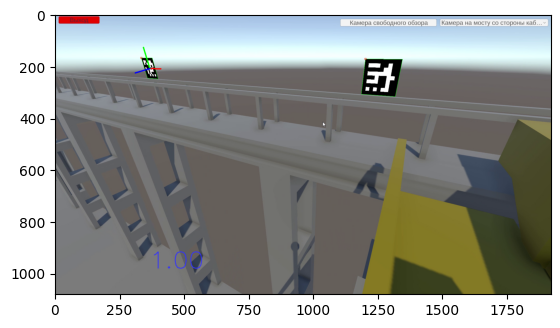

[[ 0.95529976  0.11089855 -0.27405086  9.94120904]
 [-0.29290886  0.48072318 -0.82650446  7.09785846]
 [ 0.04008445  0.86983144  0.49171791 -1.73246604]
 [ 0.          0.          0.          1.        ]]


In [12]:
frame, pose, size = estimator_rear(image_rear, True)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
print(pose)

In [13]:
# ФПС
t1 = time()
for _ in range(100):
    frame, pose, size = estimator_rear(image_rear, True)
t2 = time()
print(t2-t1, 'sec, ', 100/(t2-t1), 'fps')

1.3254058361053467 sec,  75.44858885927808 fps


In [14]:
# А вот так без отрисовки детекции на фрейме
t1 = time()
for _ in range(100):
    frame, pose, size = estimator_rear(image_rear, False)
t2 = time()
print(t2-t1, 'sec, ', 100/(t2-t1), 'fps')

1.1117372512817383 sec,  89.9493112106377 fps


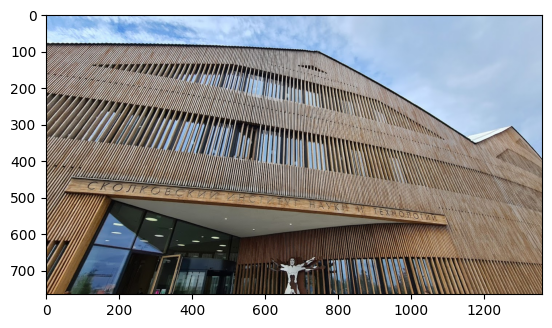

1


In [15]:
# Предсказание при отсутствии обнаружения маркеров
frame, pose, size = estimator_front(cv2.imread('demo_data/sk.jpg'), True)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.show()
print(pose)

In [16]:
# Создание экзмепляра класса PoseMultiple
estimator_mean = PoseMultiple(
    [estimator_front, estimator_rear])

In [18]:
# Случай, когда предсказывают не все эстимейторы
estimator_mean([cv2.imread('demo_data/sk.jpg'), image_rear])
# Результат равен вызову estimator_rear(image_rear)

array([[ 0.95529976,  0.11089855, -0.27405086,  9.94120904],
       [-0.29290886,  0.48072318, -0.82650446,  7.09785846],
       [ 0.04008445,  0.86983144,  0.49171791, -1.73246604],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [19]:
# Случай, когда предсказывают все эстимейторы
estimator_mean([image_front, image_rear])
# Результат равен среднему

array([[ 9.41867419e-01, -1.56755981e-02,  3.45651608e-02,
         1.86350572e+00],
       [ 3.82928916e-02,  4.65023771e-01, -8.19940481e-01,
         6.49752950e+00],
       [ 7.93694577e-04,  8.75901159e-01,  4.80723463e-01,
        -1.55377701e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [21]:
# Кооридната X предсказания:
estimator_mean([image_front, image_rear])[0,3]

1.86350571722096